# Providing a bespoke function to the temporal reduce methods

In [1]:
# If first time running, uncomment the line below to install any additional dependencies
# !bash requirements-for-notebooks.sh

In [29]:
from statsmodels import api as sm
import numpy as np
import matplotlib.pyplot as plt

from earthkit.transforms import aggregate as ek_aggregate
from earthkit import data as ek_data

from earthkit.data.testing import earthkit_remote_test_data_file
ek_data.settings.set("cache-policy", "user")

## Load some test data

All `earthkit-transforms` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray`.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data.

First we download (if not already cached) lazily load the ERA5 data (please see tutorials in `earthkit-data` for more details in cache management).

We inspect the data using the describe method and see we have some 2m air temperature data. For a more detailed representation of the data you can use the to_xarray method.

In [3]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib")
era5_data = ek_data.from_source("url", remote_era5_file)
era5_data.describe()
# era5_data.to_xarray()

,,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
shortName,typeOfLevel,,,,,,,,,
2t,surface,0,"20150301,20150302,...","0,1800,...",0,167,ea,oper,an,0001


## Reduce the ERA5 data using a bespoke function over the time dimension

The default reduction method is `mean`, other methods can be applied using the `how` kwarg.

Note that we do not need to worry about the data format of the input array, earthkit will convert it to the required xarray format internally.

### Define a bespoke function for the reduction

When providing a our own function to the reduce method it must conform the the Xarray requirements defined in their [documentation pages](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.reduce.html#xarray-dataarray-reduce). Specifically:

*"Function which can be called in the form f(x, axis=axis, \*\*kwargs) to return the result of reducing an np.ndarray over an integer valued axis."*

We will define a function which calculates the trend based on the [statsmodels Ordinary Least Squares model]https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html.

Note that you will need to install statsmodels for the following function, it is available via PyPi and conda.

In [6]:
def trend(x, axis=0, **kwargs):
    # Add a constant for the intercept
    X = sm.add_constant(np.arange(x.shape[axis]))

    _x = np.rollaxis(x, axis)
    _x_shape = _x.shape

    _x_flat = _x.reshape(_x_shape[0], -1)
    _out = np.zeros_like(_x_flat[0])
    for point in range(_x_flat.shape[1]):
        model = sm.OLS(_x_flat[:, point], X).fit()
        _out[point] = model.params[1]

    return _out.reshape(_x_shape[1:])

We can now use this method in our temporal reduce function to calculate the trend at each grid point.

In [15]:
era5_t_trend = ek_aggregate.temporal.reduce(era5_data, how=trend)
era5_t_trend

<xarray.Dataset> Size: 230kB
Dimensions:    (number: 1, step: 1, surface: 1, latitude: 201, longitude: 281)
Coordinates:
  * number     (number) int64 8B 0
  * step       (step) timedelta64[ns] 8B 00:00:00
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
Data variables:
    t2m        (number, step, surface, latitude, longitude) float32 226kB 0.0...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T14:46 GRIB to CDM+CF via cfgrib-0.9.1...

Text(0.5, 1.0, 'ERA5 2m Temperature Trend 20150101')

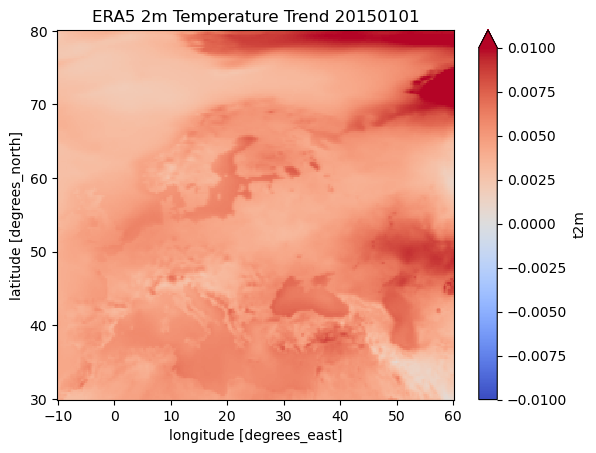

In [32]:
# A simple matplotlib plot to view the data:
era5_t_trend.t2m.plot(cmap="coolwarm", vmin=-0.01, vmax=0.01)
plt.title("ERA5 2m Temperature Trend 20150101") 